МЛ Практика 4: Задача классификации

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [45]:
df = pd.read_csv('heart_disease.csv')
df.columns = df.columns.str.strip()
df['sex'] = df['sex'].astype("category")
df['chest pain type'] = df['chest pain type'].astype("category")
df['fasting blood sugar > 120 mg/dl'] = df['fasting blood sugar > 120 mg/dl'].astype("category")
df['resting electrocardiographic results'] = df['resting electrocardiographic results'].astype('category')
df['exercise induced angina'] = df['exercise induced angina'].astype('category')
df['slope of peak'] = df['slope of peak'].astype('category')
df['Disease'] = df['Disease'].astype('category')
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [46]:
df['thal'].unique()

array([3, 7, 6], dtype=int64)

In [47]:
df['thal_test_disease'] = np.where(df['thal'] >= 6, 1, 0)
df['thal_test_disease'] = df['thal_test_disease'].astype('category')

y = df['thal_test_disease']
X = df.drop('thal_test_disease', axis=1)

X = X.drop('thal', axis=1)
df.drop('thal', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   age                                   270 non-null    int64   
 1   sex                                   270 non-null    category
 2   chest pain type                       270 non-null    category
 3   resting blood pressure                270 non-null    int64   
 4   serum cholestoral in mg/dl            270 non-null    int64   
 5   fasting blood sugar > 120 mg/dl       270 non-null    category
 6   resting electrocardiographic results  270 non-null    category
 7   maximum heart rate achieved           270 non-null    int64   
 8   exercise induced angina               270 non-null    category
 9   oldpeak                               270 non-null    float64 
 10  slope of peak                         270 non-null    category
 11  number

In [48]:
category_columns: list[str] = X.select_dtypes(include=['category']).columns
X = pd.get_dummies(X, columns=category_columns,drop_first=True)

<h4>1.2 Проверка баланса</h4>
Проверка, насколько сбалансированы классы в нашей целевой переменной:


In [49]:
y.value_counts()

thal_test_disease
0    152
1    118
Name: count, dtype: int64

<h4>1.3 Создание искусственного дисбаланса классов</h4>
Создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1:

In [50]:
from sklearn.utils import resample

data = pd.concat([X, y], axis=1)

majority = data[data['thal_test_disease'] == 0]
minority = data[data['thal_test_disease'] == 1]

minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

data_disbalanced = pd.concat([majority, minority_downsampled])

X_disbalanced = data_disbalanced.drop('thal_test_disease', axis=1)
y_disbalanced = data_disbalanced['thal_test_disease']

In [51]:
print(y_disbalanced.value_counts())

thal_test_disease
0    152
1     15
Name: count, dtype: int64


In [52]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_disbalanced, y_disbalanced)

In [53]:
y_res.value_counts()

thal_test_disease
0    152
1    152
Name: count, dtype: int64

<h4>1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе<h4>


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [55]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9607843137254902

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       0.00      0.00      0.00         2

    accuracy                           0.96        51
   macro avg       0.48      0.50      0.49        51
weighted avg       0.92      0.96      0.94        51



C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.

In [56]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 51}

<h4>1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое</h4>

In [57]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('thal_test_disease', axis=1)
y_balanced = data_balanced['thal_test_disease']

In [58]:
print(y_balanced.value_counts())


thal_test_disease
0    118
1    118
Name: count, dtype: int64


In [59]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [60]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))


Accuracy: 0.7605633802816901

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77        34
           1       0.81      0.70      0.75        37

    accuracy                           0.76        71
   macro avg       0.77      0.76      0.76        71
weighted avg       0.77      0.76      0.76        71



In [61]:
unique, counts = np.unique(y_pred_bal, return_counts=True)
dict(zip(unique, counts))

{0: 39, 1: 32}

получше👍

In [62]:
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

scaler = MinMaxScaler()

X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [63]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [64]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.7183098591549296

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72        34
           1       0.76      0.68      0.71        37

    accuracy                           0.72        71
   macro avg       0.72      0.72      0.72        71
weighted avg       0.72      0.72      0.72        71



In [65]:
unique, counts = np.unique(y_pred_bal, return_counts=True)

dict(zip(unique, counts))

{0: 38, 1: 33}

<h4>2. Метрики качества классификации</h4>

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}


In [67]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        34
           1       0.76      0.68      0.71        37

    accuracy                           0.72        71
   macro avg       0.72      0.72      0.72        71
weighted avg       0.72      0.72      0.72        71



In [68]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[26,  8],
       [12, 25]], dtype=int64)

In [69]:
rounded_items

{'True Negatives (TN)': 26,
 'False Positives (FP)': 8,
 'False Negatives (FN)': 12,
 'True Positives (TP)': 25,
 'Accuracy': 0.72,
 'Precision': 0.76,
 'Recall': 0.68,
 'F1-score': 0.71,
 'ROC-AUC': 0.72}

<h4>3. Задача мультиклассовой классфикации</h4>
Задача мультиклассовой классификации - когда мы хотим предсказать сразу несколько классов


In [70]:
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category
X = pd.get_dummies(X, columns=category_columns,drop_first=True)

In [71]:
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [72]:
y = df['resting blood pressure']

X = df.drop(['resting blood pressure', 'thal'], axis=1)

In [73]:
blood_categories = [130, 140, 150, 160, 170]
def find_cat(cat):
    return min(blood_categories, key=lambda x: abs(x - cat))
df['blood_cat'] = df['resting blood pressure'].apply(find_cat)
del df['resting blood pressure']


In [74]:
y = df['blood_cat']

X = df.drop(['blood_cat', 'thal'], axis=1)

In [75]:
X

,age,sex,chest pain type,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,Disease,thal_test_disease
0,70,1,4,322,0,2,109,0,2.4,2,3,1,0
1,67,0,3,564,0,2,160,0,1.6,2,0,0,1
2,57,1,2,261,0,0,141,0,0.3,1,0,1,1
3,64,1,4,263,0,0,105,1,0.2,2,1,0,1
4,74,0,2,269,0,2,121,1,0.2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,199,1,0,162,0,0.5,1,0,0,1
266,44,1,2,263,0,0,173,0,0.0,1,0,0,1
267,56,0,2,294,0,2,153,0,1.3,2,0,0,0
268,57,1,4,192,0,0,148,0,0.4,2,0,0,1


<h4>3.1 Алгоритм дерева принятия решений</h4>

In [76]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [77]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

         130       0.69      0.61      0.65        56
         140       0.19      0.23      0.21        13
         150       0.00      0.00      0.00         5
         160       0.20      0.25      0.22         4
         170       0.00      0.00      0.00         3

    accuracy                           0.47        81
   macro avg       0.22      0.22      0.22        81
weighted avg       0.52      0.47      0.49        81



In [78]:
accuracy_score(y_test_multi, y_pred_multi)

0.4691358024691358

In [79]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)

0.21758241758241756

Важность признаков

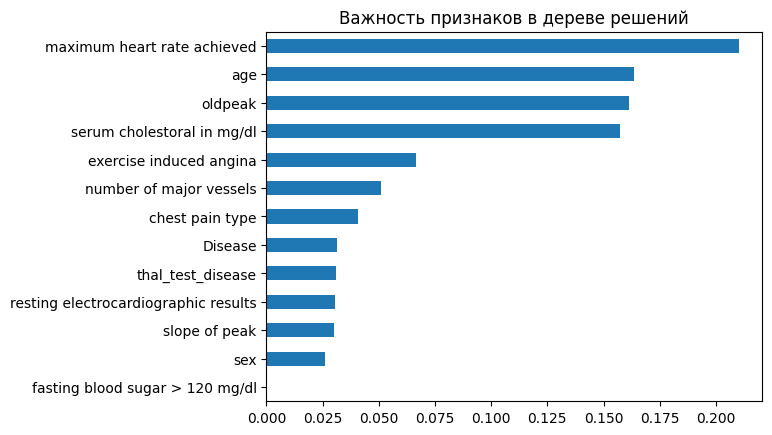

In [80]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

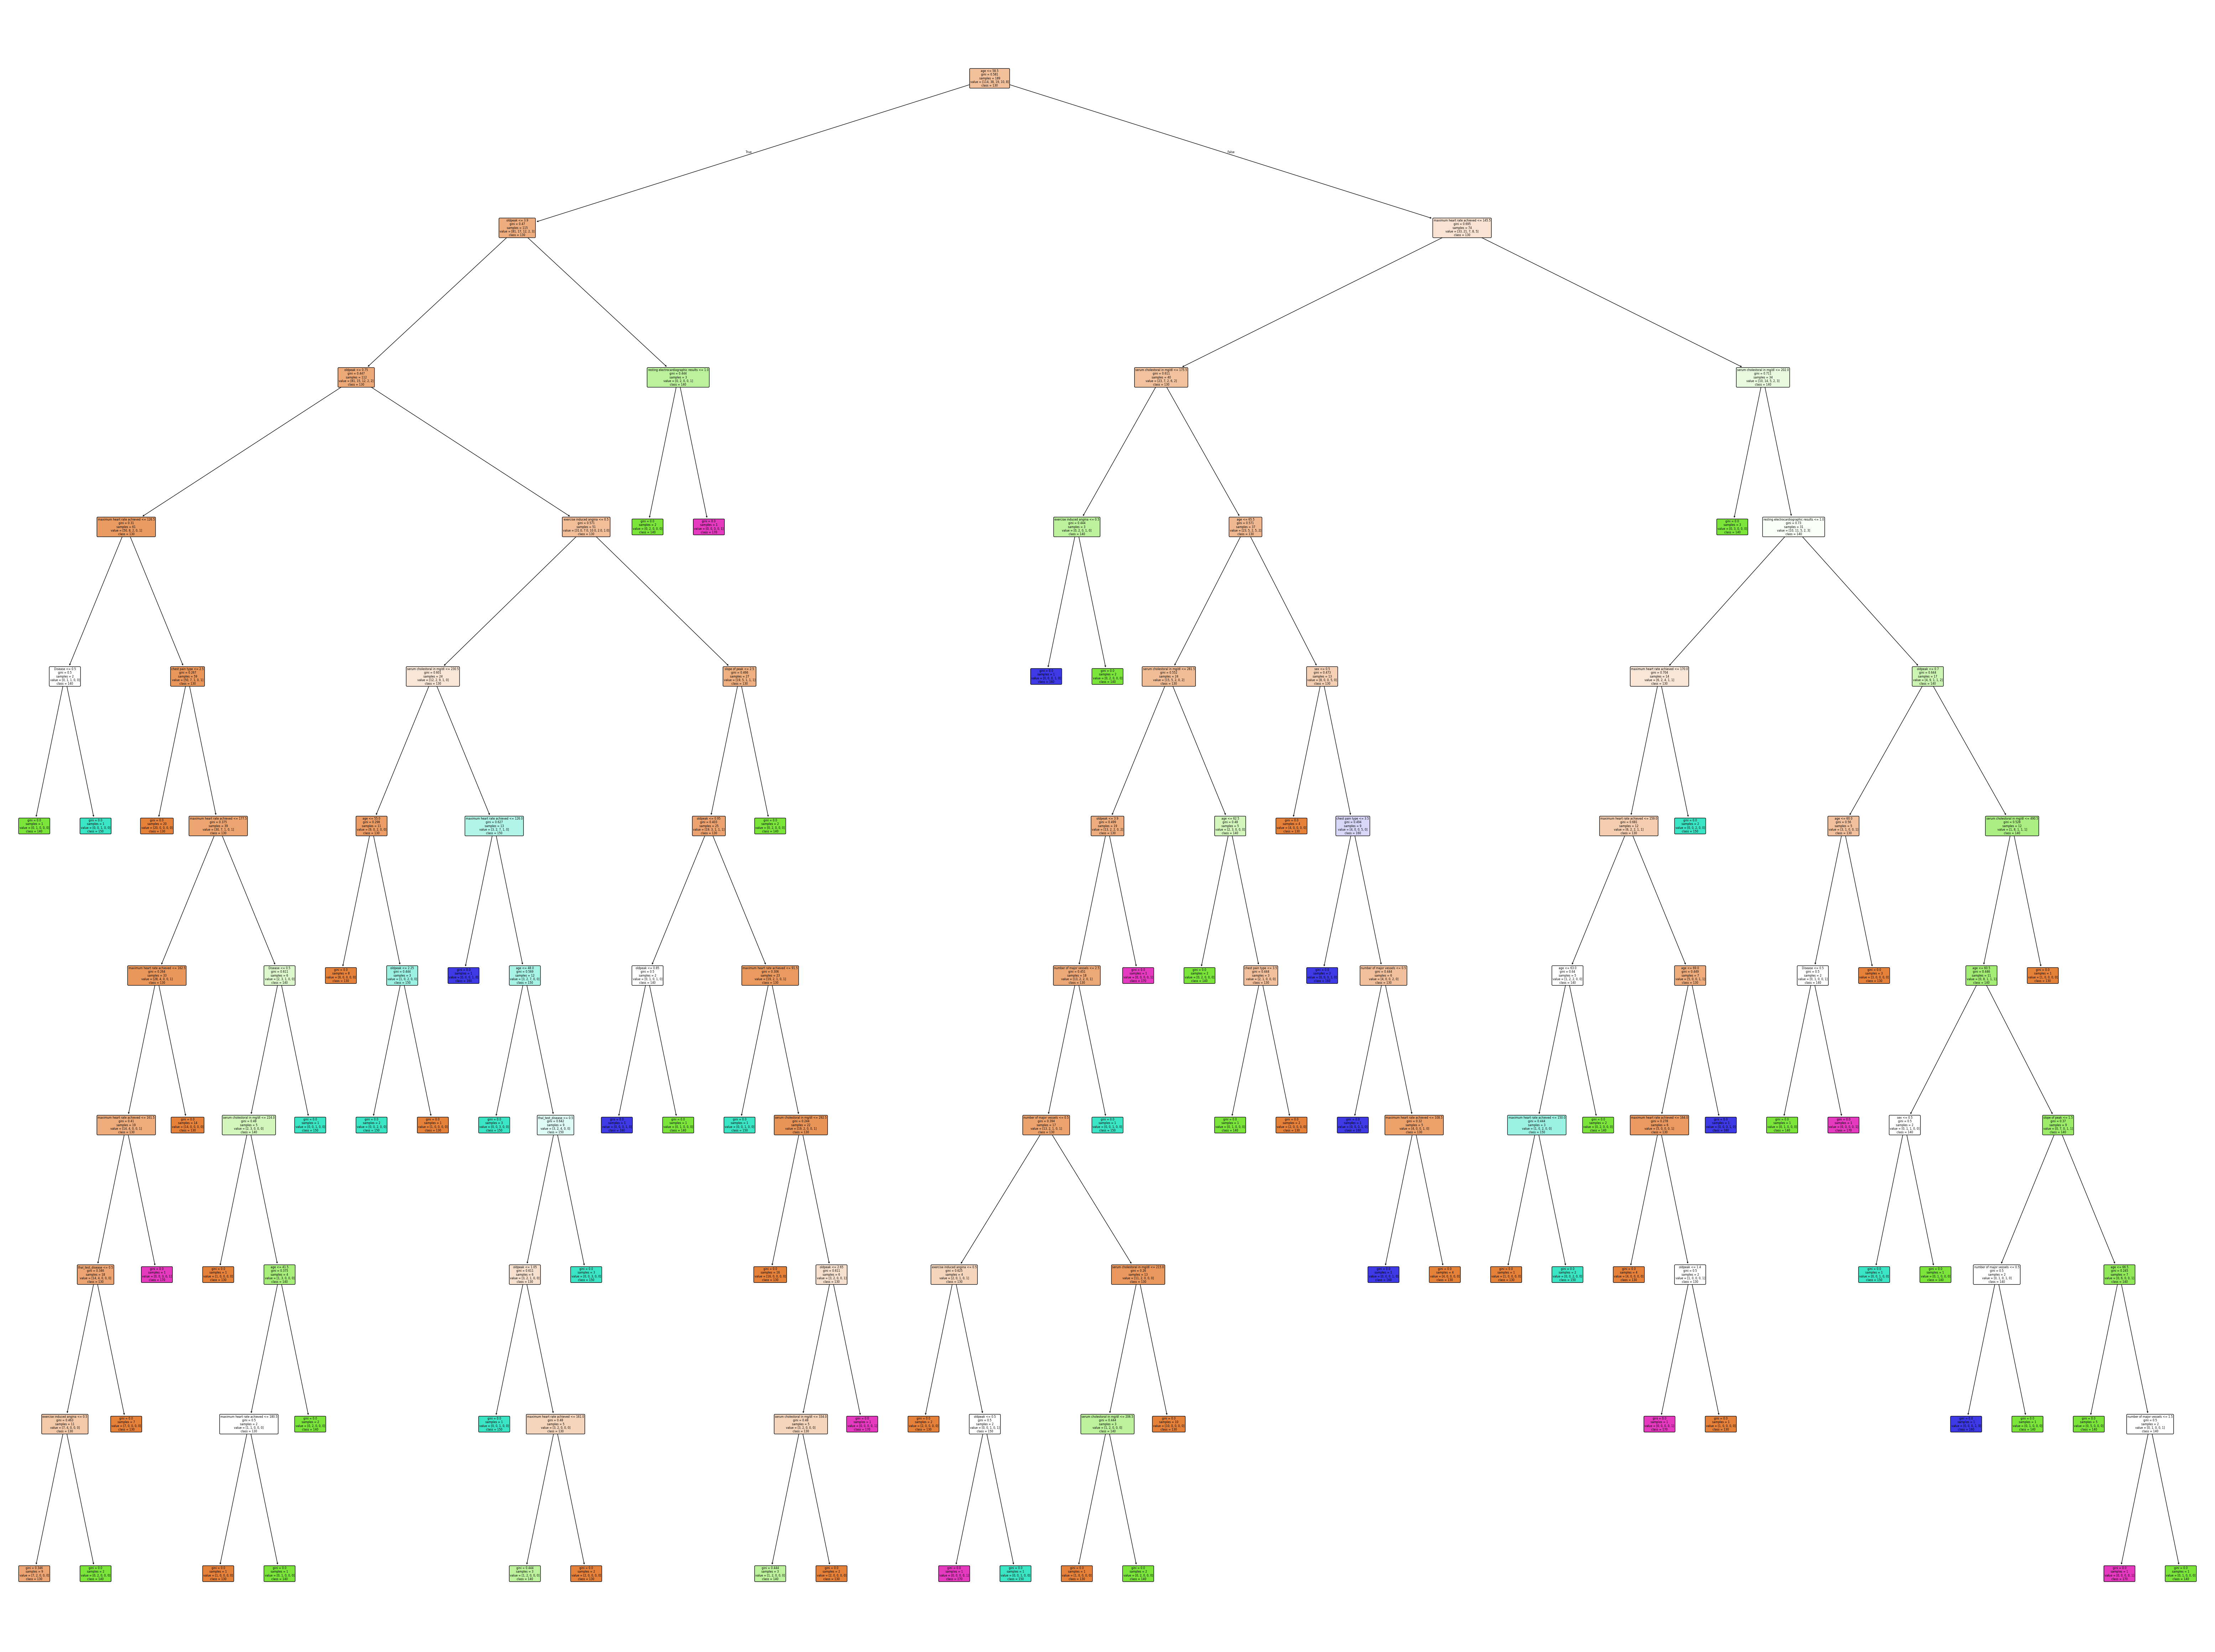

In [81]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()
